# Pre-Trained Models for Computer Vision

In [ ]:
#############
## IMPORTS ##
#############

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt


In [ ]:
###########################
## EXPLORE THE DATA SET ##
##########################

# The CIFAR-10 dataset is a widely used benchmark dataset in computer
# vision and deep learning. It contains 60,000 color images (in the PyTorch
# implementation 50,000 are grouped into the training set and 10,000 are for test)
# , each image is of size 32x32 pixels, and the images are divided into 10 classes:
#
#     0: airplane
#     1: automobile
#     2: bird
#     3: cat
#     4: deer
#     5: dog
#     6: frog
#     7: horse
#     8: ship
#     9: truck


cifar10 = datasets.CIFAR10(
    root="./data",
    train=True, # Get the training portion of the data set. Does not really matter here.
    download=True,
    transform= transforms.ToTensor() # Conver the data to tensors
)

# Get the class names and print them. There are 10 total classes in the data set
class_names = cifar10.classes
print(class_names)

# Format the data using DataLoader, which is common when working with PyTorch models. Here we use a batch size
# of 16 because we want to display 15 images below.
loader = DataLoader(cifar10, batch_size=16,shuffle=True)

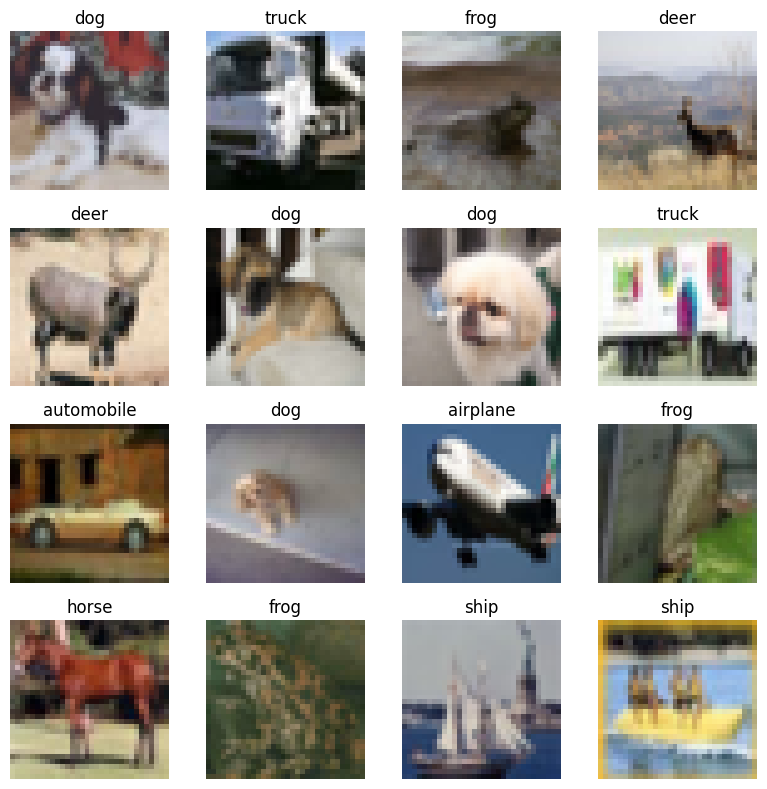

In [ ]:
# Pull the images and labels from the data loader
images, labels = next(iter(loader))

# Need to rearrange the dimensions of the images so they
# can be displayed with imshow
# Convert from (N, C, H, W) → (N, H, W, C)
images = images.permute(0, 2, 3, 1)

# Set the figure size
plt.figure(figsize=(8, 8))

# Iterate through the 16 image we want to display
for i in range(16):
    # Move to the correct subplot
    plt.subplot(4, 4, i + 1)
    # Display the image
    plt.imshow(images[i])
    # Add the correct label
    plt.title(class_names[labels[i]])
    # No axes
    plt.axis("off")


plt.tight_layout()
plt.show()


In [6]:
################################
## IMPORT AND FORMAT THE DATA ##
################################

# Define the transformations that we want to apply to the data set
transform = transforms.Compose([
    # For Resnet, EfficientNet, and MobileNet the images need to be exactly 224x224 pixels. This is because all three models were
    # trained using ImageNet. ImageNet is a collection of labeled images, 14 million images covering 20,000 categories. Haveing already
    # beeen trained on ImageNet, or at least a subset of ImageNet, means that the network can already recognize many different objects.
    # However, that also means that the networks are stuck to 224x224 images.
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # Mean of the images in ImageNet
        std=[0.229, 0.224, 0.225] # Standard deviation of the images in ImageNet
    )
])

# Import the training portion of the data set, transform the images. Also import the test data set
# even though we do not use it in the current code. You can adjust the code to to perform a evaluation
# as well as training if desired.
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)


# The training data set is 50,000 images which takes quite awhile to train. Here we truncate the training data
# to just 5,000 images to shorten the training time, though reduces the accuracy. Fill free to adjust this as
# needed.
N = 5000
subset_indices = list(range(N))
train_dataset = Subset(train_dataset, subset_indices)

# Load te data into DataLoader so the data can be more easily passed to the PyTorch models
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [7]:
######################
## DEVICE SELECTION ##
######################

# Check to see if a Nvidia GPU and the CUDA library are avaliable. If they are, offload the expensive
# calculations to the GPU to increase the speed. If not avaliable, just use the CPU for calculations.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
###########################
## FREEZE MODEL FUNCTION ##
#############################

# Function to freeze all the parameters in a model. This means that any portion of the network that 
# we pass through this function will not be updated during training.
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False


## ResNet, MobileNet, and EfficientNet

In [9]:
####################
## RESNET50 MODEL ##
#####################

# ResNet50 comes from the ResNet (Residual Network) family of models developed by Microsoft. ResNet was developed tp
# solve a problme: as a neural network gets deeper (more layers), its accuracy can actually decrease. This is because as the
# network gets deeper, it becomes more difficult to train, and the gradients can vanish or explode. ResNet solves this problem by introducing
# skip connections, which allow the gradients to flow more easily through the network. This allows for much deeper networks to be trained effectively.
# Intuitively, skip connections allow the network to "skip" over layers, which helps to preserve the gradient during backpropagation if they do not
# need to make any changes.

# ResNet50 is a 50-layer version of ResNet, and is a good balance between accuracy and computational efficiency. If interested you can look
# up the architecture of ResNet50 online to see how the layers are arranged. It involves convolutional layers, max pooling, global pooling,
# and a final fully connected layer for classification.

# Import the ResNet model. Note that there are different ResNet models avaliable such as ResNet18, ResNet34,
# ResNet101, and ResNet152. The larger the number, the more layers in the network, and generally the more accurate
# the model is, but also the more computationally expensive it is to train and use. All of these models are also 
# pretrained on ImageNet, but there are different weights avaliable depending on the version of training used. 
# See the PyTorch documentation for more details.
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Here we freeze all of the layers in the ResNet so its parameters are not updated during training.
# This allows us to use the pretrained features of ResNet without modifying them. If we did not
# freeze the model, then all of the parameters in ResNet would be updated during training. You can
# adjust this as needed, but the training process will take longer if you do not freeze the model.
# ResNet50 has 23.5 million parameters, so training all of them would take a long time.
freeze_model(resnet)

# Now we add a single linear layer to the end of ResNet to convert the 1000 output features
# from ResNet to the 10 output features needed for CIFAR10. This layer will be the only portion
# of the network that is trained.
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

# Move the model to the selected device (GPU or CPU)
resnet = resnet.to(device)


In [10]:
#######################
## MOBILENETV2 MODEL ##
#######################

# MobileNetV2 is a convolutional neural network architecture that is designed to be efficient and 
# suitable for mobile and embedded vision applications. It is an improvement over the original MobileNet architecture,
# which was already optimized for speed and low computational cost. The core idea behind MobileNetV2 is the use of
# depthwise separable convolutions, which significantly reduce the number of parameters and computational requirements by 
# performing a depthwise convolution followed by a pointwise convolution, instead of a standard convolution. This is 8-9x
# more computationally efficient than standard convolutions, making MobileNetV2 much faster and lighter weight.

# If interested, you can look up the architecture of MobileNetV2 online to see how the layers are arranged. 

mobilenet = models.mobilenet_v2(
    weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
)
freeze_model(mobilenet)

mobilenet.classifier[1] = nn.Linear(
    mobilenet.classifier[1].in_features, 10
)
mobilenet = mobilenet.to(device)


In [11]:
########################
## EFFICIENTNET MODEL ##
########################

# EfficientNet is a family of convolutional neural networks developed by Google AI that are designed to be both accurate and efficient. 
# Different networks try to increase accuracy by either making the network deeper (more layers) or wider (more neurons per layer) or
# using higher resolution images. However, these approaches often lead to diminishing returns, where increasing one dimension
# (depth, width, or resolution) leads to only small improvements in accuracy while significantly increasing computational cost.
# EfficientNet uses a technique called compound scaling to scale the depth, width, and resolution of the network in a balanced way. 
# Think of it as EfficientNet finding the "sweet spot" between these three dimensions, they grow proportionally.
# This allows EfficientNet to achieve high accuracy while using fewer parameters and less computational resources compared to other models.

# If you are interested, you can look up the architecture of EfficientNet-B0 online to see how the layers are arranged and also how the
# different dimensions are scaled. Note that EfficientNet comes in different sizes, from B0 to B7, with B0 being the smallest and least 
# computationally expensive. EfficientNet uses ideas from MobileNet and ResNet, such as depthwise separable convolutions and skip connections, 
# to further improve efficiency and accuracy.

efficientnet = models.efficientnet_b0(
    weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
)
freeze_model(efficientnet)

efficientnet.classifier[1] = nn.Linear(
    efficientnet.classifier[1].in_features, 10
)
efficientnet = efficientnet.to(device)


In [12]:
###################################
## TRAINING FUNCTION (ONE EPOCH) ##
###################################

# This function trains the given model for one epoch using the provided dataloader.
# It uses the Adam optimizer and Cross Entropy Loss for training. I've set the training
# to just one epoch for simplicity and time savings, but you can adjust this as needed.
# Remember that for the above models, only the final linear layer is being trained, as the
# rest of the model has been frozen.
def train_one_epoch(model, dataloader):
    # Set the model to training mode
    model.train()
    # Define the optimizer and loss function. The learning rate of the optimizer as been set to a 
    # constant. This can be changed to other constants or a learning rate scheduler can be used.
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_func = nn.CrossEntropyLoss()

    # Variables to keep track of predictions
    correct = 0
    total = 0

    # If you wanted to have more than one trainging iteration, indent the below code and add a for 
    # loop here over the training epochs.

    # Pull the images and labels from the data loader
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Clear the previous gradients from the optimizer
        optimizer.zero_grad()
        # Pass the data through the network and get the loss
        outputs = model(images)
        loss = loss_func(outputs, labels)
        # Compute the gradients and use the optimizer and gradients to update the parameters
        loss.backward()
        optimizer.step()

        # Compute and save the total number of correct predictions and the total number of predictions
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Accuracy is the number of correct predictions divided by the total number of predictions, multiplied by 100
    # to make a percent.
    acc = correct / total
    return  acc*100


In [13]:
######################
## TRAIN THE MODELS ##
######################

# Combine the models to train in a dictionary with the name of the model
models_dict = {
    "ResNet50": resnet,
    "EfficientNetB0": efficientnet,
    "MobileNetV2": mobilenet,
}

# Train the models
for name, model in models_dict.items():
    acc = train_one_epoch(model, train_loader)
    print("Model", name, "Accuracy:", acc, "%")

# This took approximately  on my Windows Desktop (cpu)
    ## Resnet ~7 min
    ## Eficient ~2 min
    ## Mobile ~2 min
# As a note these times are for one training epoch, only 5,000 training images (of the 50,000) avaliable,
# and only training the parameters that connect the pre-trained model and the output layer. Runtimes can
# increase drastically for more realistic problems.

Model ResNet50 Accuracy: 57.42 %
Model EfficientNetB0 Accuracy: 57.4 %
Model MobileNetV2 Accuracy: 55.14 %


## Inception

In [14]:
###############################
## INPUT AND FORMAT THE DATA ##
###############################

# Inception input size requirements: InceptionV3 was trained on ImageNet images of size 299x299 pixels.
# The network uses large kernels and pooling operations that reduce spatial dimensions at each stage. 
# Feeding smaller images (e.g., 224x224) can cause errors because some feature maps become too small 
# for later convolutions and for the auxiliary classifier. Using 299x299 ensures that the feature maps 
# are large enough at every layer and preserves the network's performance on small objects.

transform = transforms.Compose([
    transforms.Resize((299, 299)), # New size requirements
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# The rest of this is the same as above, just with the new transforms
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

N = 5000
subset_indices = list(range(N))
train_dataset = Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [15]:
##################
## INCEPTION V3 ##
##################

# InceptionV3 is a convolutional neural network (CNN) architecture developed by Google 
# (Szegedy et al., 2016) for image classification. It is an improved version of earlier 
# Inception networks, designed to be more efficient while achieving high accuracy on 
# large-scale datasets such as ImageNet. It uses Inception models that apply multiple
# convolutions in parallel and concatenate the results. Inception also includes 
# auxillary classifiers partway through the network to help with gradient flow.

# The auxiliary classifier computes its own classification outputs partway through the
# model to provide an additional loss during the training process. Its a "helper" for the
# full loss.

# The Inception architecture is especially interesting if you want to read the original
# paper linked at the end of the notebook.

inception = models.inception_v3(
    weights=models.Inception_V3_Weights.IMAGENET1K_V1,
    aux_logits=True   # Use the auillary classifier
)

freeze_model(inception)   

# Replace BOTH classifiers (the final classifier and the aux classifier)
inception.fc = nn.Linear(inception.fc.in_features, 10)
inception.AuxLogits.fc = nn.Linear(
    inception.AuxLogits.fc.in_features, 10
)

inception = inception.to(device)


In [16]:
#################################
## TRAIN INCEPTION (ONE EPOCH) ##
#################################

# This function is very similar to the above function, so I will only point out the differences
# needed for the auxiliary classifier.

def train_one_epoch(model, dataloader):
    model.train()
    correct = 0
    total = 0

    loss_func = nn.CrossEntropyLoss()

# The optimizer needs to update the parameters of the main model and the output layer of the
# auxiliary classifier
    optimizer = optim.Adam(
        list(inception.fc.parameters()) +
        list(inception.AuxLogits.fc.parameters()),
        lr=1e-3
    )


    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, aux_outputs = model(images)

        # Need to compute both losses
        loss_main = loss_func(outputs, labels)
        loss_aux  = loss_func(aux_outputs, labels)

        # This part is changeable as you like, but need to combine both losses into a single 
        # loss.
        loss = loss_main + 0.4 * loss_aux

        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total

    return acc*100


In [ ]:
#####################
## TRAIN INCEPTION ##
####################

# This is the same as above
models_dict = {
    "InceptionV3": inception
}

for name, model in models_dict.items():
    acc = train_one_epoch(model, train_loader)
    print("Model", name, "Accuracy:", acc, "%")


# This took approximately 9 mins on my Windows Desktop (cpu)

## Conclusion and Further Resources

In the next few lessons we will be looking at pre-trained models for object detection (YOLO and SSD) and for image segmentation (U-Net). Moving beyond pre-trained neural networks and convolutional neural networks, there are also pre-trained transformers (as seen the the RAG lesson). In addition to natural language processing, transformers can also be used to analyze images, so called vision transformers. Examples of vision transformers are ViT, Swin, and CLIP. We will not be learning vision transformers in this class, making them a possible topic for a final project.

* [Image-Net](https://www.image-net.org/index.php)
* [Original Paper for ResNet](https://arxiv.org/abs/1512.03385)
* [Original Paper for MobileNetV2](https://arxiv.org/abs/1801.04381)
* [Original Paper for EfficientNet](https://arxiv.org/abs/1905.11946)
* [Original Paper for Inception](https://arxiv.org/abs/1512.00567)
* [PyTorch Documenation: Models and pre-trained weights](https://docs.pytorch.org/vision/stable/models.html)
* [Deep Learning for Computer Vision (Stanford Course Lecture Notes)](https://cs231n.github.io/)
* [ResNet (34, 50, 101): Residual CNNs for Image Classification Tasks](https://neurohive.io/en/popular-networks/resnet/)
* [PyTOrch Documentation: Transfer Learning for Computer Vision Tutorial](http://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* [Inception Explained: Understanding the Architecture and Module of Inception Networks (Video)](https://www.youtube.com/watch?v=STTrebkhnIk)
* [Residual Networks and Skip Connections (Video)](https://www.youtube.com/watch?v=Q1JCrG1bJ-A)
* [Inception, ResNet, MobileNet](https://medium.com/@fransiska26/the-differences-between-inception-resnet-and-mobilenet-e97736a709b0)